<a href="https://colab.research.google.com/github/TitasDas/poc-insights-from-images/blob/main/object%20detection/object_detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**


In [1]:
import os
import pathlib

import tensorflow as tf
import tensorflow_hub as hub

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import matplotlib
import matplotlib.pyplot as plt

import csv

from google.colab import drive

tf.get_logger().setLevel('ERROR')

In [ ]:
# getting tensorflow models 
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
%matplotlib inline

#**Utility**


*   Collection of models available and their respective hub handles to see the architecture and what dataset they were trained on.

*   Helper function to load images and convert them to a numpy array.



In [5]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

In [7]:
def load_image_data_into_nparray(file_):
  image_data = tf.io.gfile.GFile(file_, 'rb').read()
  image = Image.open(BytesIO(image_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)

**Loading test images**


*   Commented code has the ability to load images from public links. (**additional testing feature)




In [6]:
drive.mount('/content/drive')
test_images = []

#change the path to enable loading images from the public link instead of drive
# if(path.startswith('http')):
#     response = urlopen(path)
#     image_data = response.read()
#     image_data = BytesIO(image_data)
#     image = Image.open(image_data)

with os.scandir(path = '/content/drive/MyDrive/Dataset/uniqlousa') as files:
  for file_ in files:
    if file_.name.endswith('.jpg'):
      test_images.append(file_)
print(len(test_images))

Mounted at /content/drive
2263


**Checking labels available (seen objects)**

For starters we have loaded the labels available to us from the API. However anything that returns a dictionary mapping integers to string labels would be fine here. We need to make sure the objects that we are looking for are available to us as labels.

*   Can just adding an appropriate label (available in ms coco2017) improve results?







In [8]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index.values())

#converting the dictionary to a csv file
with open('labels.csv', 'w') as f:
    for key in category_index.keys():
        f.write("%s,%s\n"%(key,category_index[key]))

# TODO: 
# rewrite the part where the conversion to an excel file is done using pandas.

dict_values([{'id': 1, 'name': 'person'}, {'id': 2, 'name': 'bicycle'}, {'id': 3, 'name': 'car'}, {'id': 4, 'name': 'motorcycle'}, {'id': 5, 'name': 'airplane'}, {'id': 6, 'name': 'bus'}, {'id': 7, 'name': 'train'}, {'id': 8, 'name': 'truck'}, {'id': 9, 'name': 'boat'}, {'id': 10, 'name': 'traffic light'}, {'id': 11, 'name': 'fire hydrant'}, {'id': 13, 'name': 'stop sign'}, {'id': 14, 'name': 'parking meter'}, {'id': 15, 'name': 'bench'}, {'id': 16, 'name': 'bird'}, {'id': 17, 'name': 'cat'}, {'id': 18, 'name': 'dog'}, {'id': 19, 'name': 'horse'}, {'id': 20, 'name': 'sheep'}, {'id': 21, 'name': 'cow'}, {'id': 22, 'name': 'elephant'}, {'id': 23, 'name': 'bear'}, {'id': 24, 'name': 'zebra'}, {'id': 25, 'name': 'giraffe'}, {'id': 27, 'name': 'backpack'}, {'id': 28, 'name': 'umbrella'}, {'id': 31, 'name': 'handbag'}, {'id': 32, 'name': 'tie'}, {'id': 33, 'name': 'suitcase'}, {'id': 34, 'name': 'frisbee'}, {'id': 35, 'name': 'skis'}, {'id': 36, 'name': 'snowboard'}, {'id': 37, 'name': 'spor

**Saving as csv**

The mapping of id to object label is saved as a csv file.  

In [ ]:
#comment this out when running locally
!cp labels.csv "drive/My Drive/"

In [ ]:
#for testing using only the first 10 images from the test images (this cell takes time to execute)

# TODO: 
# prepare dictionary of numpy arrays

#image_np_dict = {im.name:load_image_data_into_nparray(im) for im in test_images[:1]}

# **Loading model**

In [10]:
chosen_model = 'Faster R-CNN Inception ResNet V2 1024x1024'
model_handle = ALL_MODELS[chosen_model]
print('Selected model :' + chosen_model)
print('Model Handle at TF hub: {}'.format(model_handle))
hub_model = hub.load(model_handle)
print('model loaded!')

Selected model :Faster R-CNN Inception ResNet V2 1024x1024
Model Handle at TF hub: https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1
model loaded!


# **Running model**

In [ ]:
#can use multiple images using dict where key is file name and value is file path with 10 selected images
path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-04-01_14-00-10_UTC.jpg'
image_np = load_image_data_into_nparray(path)
print(image_np)

[[[[ 68  33  29]
   [ 87  46  40]
   [120  68  57]
   ...
   [189 125  97]
   [184 120  92]
   [179 115  87]]

  [[ 76  41  39]
   [ 90  49  43]
   [118  68  57]
   ...
   [181 117  90]
   [177 113  86]
   [172 108  81]]

  [[ 80  45  43]
   [ 91  50  44]
   [117  67  56]
   ...
   [174 112  89]
   [171 109  86]
   [167 105  82]]

  ...

  [[247 242 236]
   [248 243 237]
   [248 243 237]
   ...
   [208 200 187]
   [221 212 197]
   [240 228 212]]

  [[248 243 237]
   [247 242 236]
   [247 242 236]
   ...
   [182 174 161]
   [187 178 163]
   [205 193 177]]

  [[248 243 237]
   [247 242 236]
   [246 241 235]
   ...
   [200 190 178]
   [184 175 160]
   [184 172 156]]]]


In [ ]:
results = hub_model(image_np)
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes', 'num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores'])


# **Results**

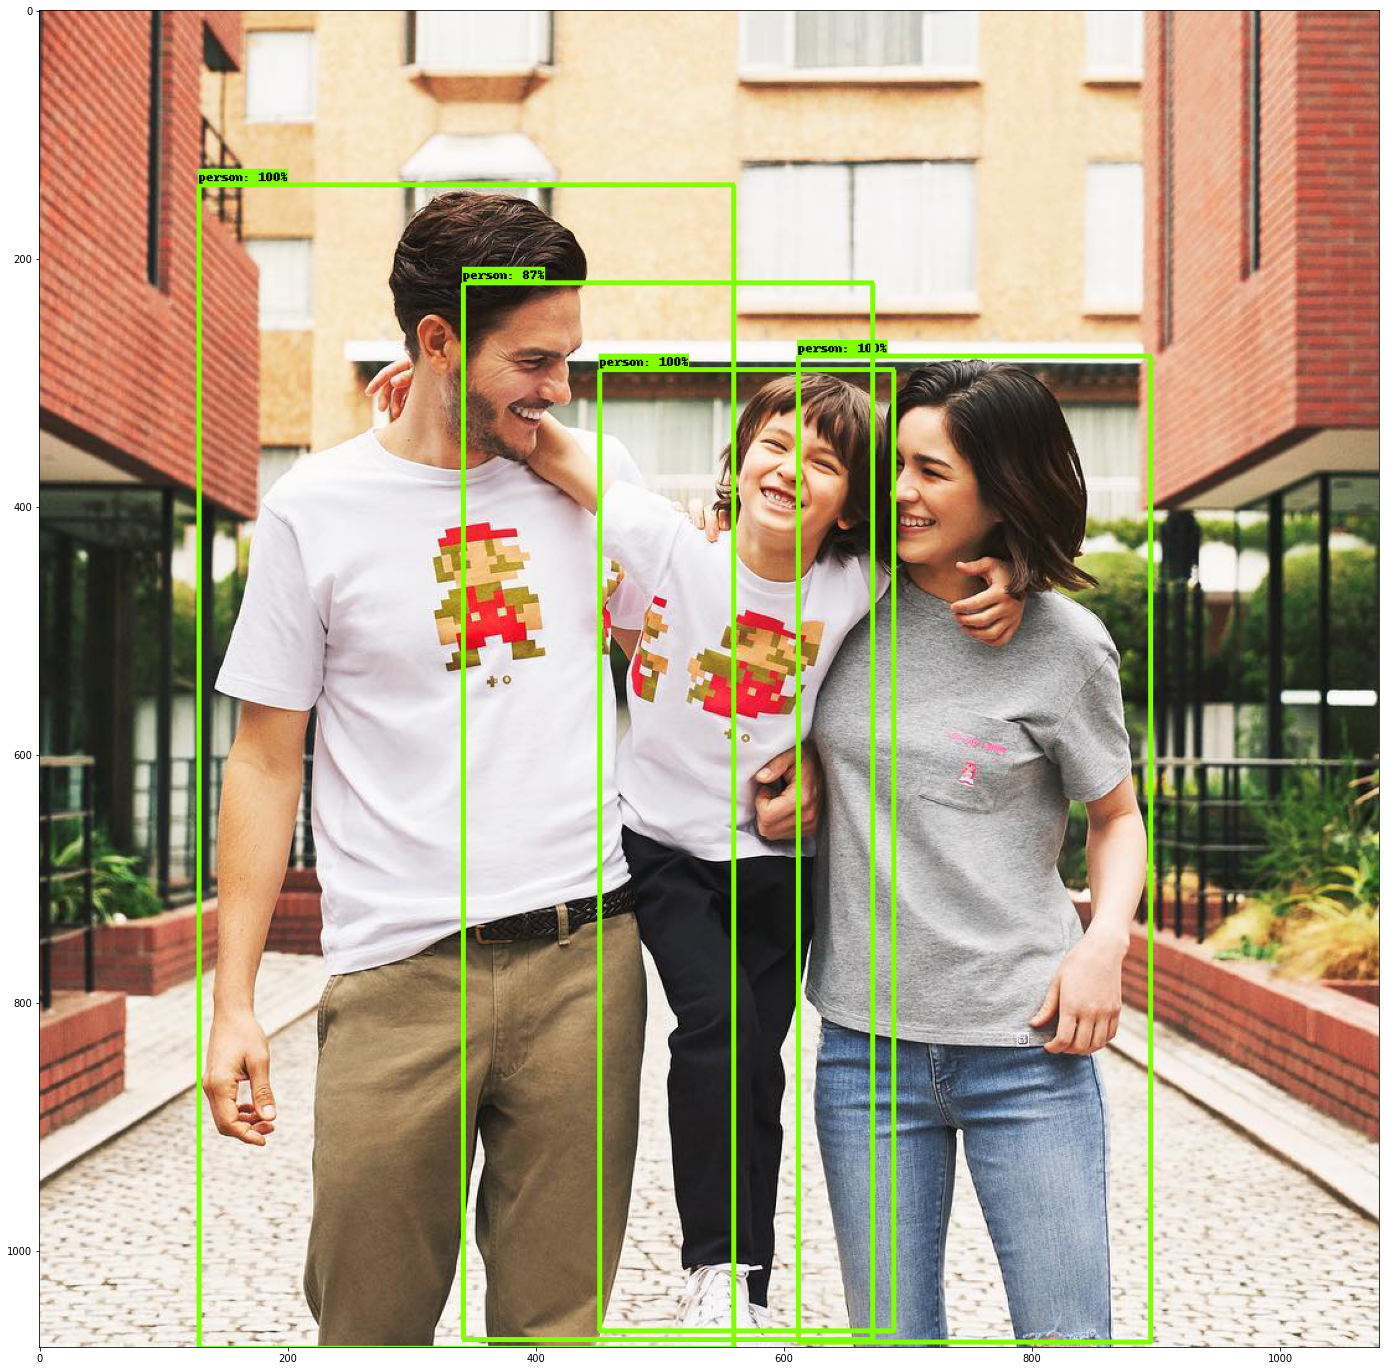

In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

**Additional test images**

In [ ]:
# all the images that were presented as results of the first iteration

# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-09_20-23-28_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-29_15-43-18_UTC_1.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-04-23_13-55-56_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-12_15-58-50_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-31_15-06-53_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-03-15_15-06-26_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-01_20-58-46_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-22_21-18-59_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-06-26_15-18-46_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-28_15-37-03_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-05-17_14-51-48_UTC.jpg'
# path = '/content/drive/MyDrive/Dataset/uniqlousa/2019-06-20_14-55-16_UTC.jpg'

image_np = load_image_data_into_nparray(path)
results = hub_model(image_np)
result = {key:value.numpy() for key,value in results.items()}
label_id_offset = 0
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,24))
plt.imshow(image_np_with_detections[0])
plt.show()